# Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)



This notebook accompanies the blog "Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)" (TODO: add link)

## Introduction
When transcribing speech containing domain-specific terminologies in fields such as legal, financial, construction, higher education, or engineering, [Amazon Transcribe’s](https://aws.amazon.com/transcribe/) [custom vocabularies](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html) feature can improve transcription quality, especially on key technical terms. 

To use custom vocabularies with Amazon Transcribe, you need a list of domain-specific terms. Using a collection of videos or audio files (i.e., your dataset) that you want transcribed with high accuracy, you can send a portion of your dataset to Amazon Transcribe to identify terms it has difficulty with, indicated by low-confidence scores. You can use [Amazon Augmented AI (A2I)](https://aws.amazon.com/a2i/) to send these low-confidence predictions directly to a human to manually review and transcribe the terms. This walkthrough will demonstrate how you can process the results obtained from Amazon A2I to quickly to build a custom vocabulary, at scale.

In summary, in this walkthrough you will:
* Send a subset of videos to Amazon Transcribe to find terms that are difficult to transcribe.
* Set up a human review workflow using Amazon A2I to send low-confidence predictions to your human workforce for manual review and transcription.
* Create a custom vocabulary using the results obtained from human workers.
* Test Amazon Transcribe on another subset of videos to assess the improvement in transcription quality. 

![mistranscription](./images/mistranscription_example_2.png)
Example of a mis-transcription in an AWS tutorial video of the domain-specific terms "R," "Keras," and "PyTorch" on YouTube's auto-generated English closed captions. The terms were mis-transcribed as "our," "chaos," and "pi torch," respectively.

## Solution Overview:

The following diagram presents the solution architecture:

![solution architecture](./images/solution_architecture.png)

## Prerequisites

To run this notebook, you can simply execute each cell in order. Before beginning, you'll need:

* An AWS account.
* An S3 bucket you can write to - please provide its name in `BUCKET`. The bucket must be in the same region as this SageMaker Notebook instance. All the video files involved in this demo will be stored in `s3://BUCKET/a2i_transcribe_demo`. All A2I results will be stored in `s3://BUCKET/a2i-results/`. All Amazon Trasncribe results will be stored in `s3://BUCKET/transcribe-results/`.

To help understand this demo, the following are also recommended:
1. Basic understanding of AWS services [Amazon Transcribe](https://docs.aws.amazon.com/transcribe/latest/dg/what-is-transcribe.html) and Transcribe [custom vocabularies](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html), and the core components and workflow used by [Amazon A2I](https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-use-augmented-ai-a2i-human-review-loops.html). The notebook uses the [AWS SDK for Python (Boto3)](https://aws.amazon.com/sdk-for-python/) to interact with these services.  
2. Familiarity with Python and numpy.
3. Basic familiarity with [AWS S3](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html).

This notebook has been tested on a SageMaker notebook instance. The runtimes given are approximated on an ml.t2.medium instance. You can run it on a local instance by first executing the cell below on SageMaker and then copying the name of the role to your local copy of the notebook.

For more sample notebooks using A2I, visit this [Github repository](https://github.com/aws-samples/amazon-a2i-sample-jupyter-notebooks).

Let's get started!

# Setup

### Install Latest SDKs

In [115]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip --quiet
!pip install --upgrade awscli --quiet
!pip install boto3 --upgrade --quiet
!pip install -U botocore --quiet

In [116]:
import io
import uuid
import botocore
import boto3
import re
import time
import pprint
import subprocess
import json
import sagemaker
from sagemaker import get_execution_role
from datetime import datetime, timezone

### Region, Bucket, and Paths
Make sure all your resources are stored in the same region. You'll be using the same bucket for this entire walkthrough.

In [117]:
BUCKET = 'jashuang-test-sagemaker-6-25'

if(BUCKET==''):
    BUCKET = sagemaker.Session().default_bucket()
print(f'The S3 bucket used in this demo will be: {BUCKET}')

OUTPUT_PATH_A2I = f's3://{BUCKET}/a2i-results'
OUTPUT_PATH_TRANSCRIBE = f's3://{BUCKET}/transcribe-results'

The S3 bucket used in this demo will be: jashuang-test-sagemaker-6-25


In [118]:
sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name

# Amazon S3 (S3) client
s3 = boto3.client('s3', region)
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon Transcribe client
transcribe_client = boto3.client("transcribe")

### Roles and Permissions

This is the execution role that will be used to call Amazon Transcribe and Amazon A2I. 

In [204]:
from sagemaker import get_execution_role

ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20191017T170424'

Add the following policies to this role in IAM:
* AmazonAugmentedAIFullAccess
* AmazonTranscribeFullAccess

Your execution role has the AmazonSageMakerFullAccess policy attached. This gives Amazon SageMaker permission to access your resources in S3 if the bucket or objects have the word `sagemaker` in the name. If your S3 bucket listed in `BUCKET` does not have sagemaker in the name, you will need to add an S3 policy to your execution role to give your role permissions to access your data objects in S3. The following is an example of an S3 policy:

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_input_bucket/*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:PutObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_output_bucket/*"
            ]
        }
    ]
}
```


Note: your default **Maximum CLI/API session duration** (MaxSessionDuration) for this execution role is 1 hour. It is recommended that you [increase MaxSessionDuration](https://docs.aws.amazon.com/IAM/latest/UserGuide/roles-managingrole-editing-console.html#roles-modify_max-session-duration) to 2 hours. If you take more than MaxSessionDuration-hours to complete the notebook, you will have to re-run all of the previous code cells, and all code cells that define functions below. 

### Upload Sample Video to S3
For this demo, we'll be analyzing videos from the official AWS playlist on introductory SageMaker videos, also available on [YouTube](https://www.youtube.com/watch?v=uQc8Itd4UTs&list=PLhr1KZpdzukcOr_6j_zmSrvYnLUtgqsZz&index=1). Follow the steps below to copy the mp4 video files to your own S3 bucket.

If you want to experiment with additional videos, change the S3 URI below to `s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/additional-videos/`. This will download 4 videos.

In [120]:
!rm -rf ./a2i_transcribe_demo*

In [121]:
!mkdir ./a2i_transcribe_demo
!aws s3 sync s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/transcribe-notebook-demo/ ./a2i_transcribe_demo

download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/transcribe-notebook-demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 to a2i_transcribe_demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4


In [122]:
%%bash -s "$BUCKET"
aws s3 cp ./a2i_transcribe_demo/ s3://$1/a2i_transcribe_demo/ --recursive

upload: a2i_transcribe_demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 to s3://jashuang-test-sagemaker-6-25/a2i_transcribe_demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4


In [123]:
%%bash -s "$BUCKET"
aws s3 ls s3://$1/a2i_transcribe_demo/

2020-06-26 22:01:27   40325383 Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4


In [124]:
%%capture cap_out --no-stderr
%%bash -s "$BUCKET"
aws s3 ls s3://$1/a2i_transcribe_demo/ --recursive

The following cell will define the variable `all_videos`. This will determine the number of videos that you use to run this demo. If you want to change the number of videos used in this demo, copy and paste the output from this cell, and re-define `all_videos`. 

In [125]:
VIDEOS = cap_out.stdout
all_videos = re.findall("a2i_transcribe_demo/.*",VIDEOS)
for i in range(len(all_videos)):
    all_videos[i] = all_videos[i].split('a2i_transcribe_demo/')[-1]
all_videos

['Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4']

In [126]:
num_videos = len(all_videos)
num_videos

1

In [127]:
# You can give each transcription job any name. We attach a timestamp to each job name here
# to prevent conflicting job names in case we need to re-run any jobs.
now = datetime.now()
time_now = now.strftime("%H.%M.%S")

# Path to folder
folder_path = f"s3://{BUCKET}/a2i_transcribe_demo/"

job_names = []
for i in range(num_videos):
    job_names.append("AWS-sage-vid-" + str(i) + "-" + str(time_now))

job_names

['AWS-sage-vid-0-22.01.34']

## Step 1: Initial Transcription
Our first step is to look at the performance of Amazon Transcribe “off-the-shelf” (i.e., without custom vocabulary or other modifications) and establish a baseline accuracy metrics. You can use the following `transcribe` function (mostly a wrapper around the API call) to start a transcription job. Note that the `vocab_name` parameter will be used later to specify custom vocabularies, and it’s currently defaulted to `None`.

For the purposes of this demo, we'll be transcribing the first video in the playlist. Feel free to experiment with additional videos we've provided, or your own content.

In [200]:
# Here is a transcribe function
def transcribe(job_name, job_uri, out_bucket, format="mp4", vocab_name=None):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
        vocab_name (str): name of custom vocabulary used;
                          optional, defaults to None
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        print("------" + format)
        if vocab_name is None:
            transcribe_client.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="en-US",
                OutputBucketName=out_bucket,
            )
        else:
            transcribe_client.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="en-US",
                OutputBucketName=out_bucket,
                Settings={'VocabularyName': vocab_name}
            )
        
        time.sleep(2)
        
        print(transcribe_client.get_transcription_job(TranscriptionJobName=job_name))

    except Exception as e:
        print(e)

In [201]:
## Start a transcription job
for i in range(len(job_names)):
    transcribe(job_names[i], folder_path+all_videos[i], BUCKET)

------mp4
An error occurred (ConflictException) when calling the StartTranscriptionJob operation: The requested job name already exists. Use a different job name.


### Check transcription job statuses

Wait until the status displays `COMPLETED` before moving on to the next cells. A transcription job for a 10-15 minute video typically takes roughly 5 minutes.

In [132]:
for job_name in job_names:
    print(transcribe_client.get_transcription_job(TranscriptionJobName=job_name)['TranscriptionJob']['TranscriptionJobStatus'])

COMPLETED


### Retrieve and Parse Transcription Results

When the transcription job finishes, the results will be stored in your specified S3 bucket as an output JSON file called “YOUR_JOB_NAME.json.” You can use the following function to retrieve your results, and parse them into sentences with time stamps, confidence scores, and other useful representations.

In [133]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from S3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (
        entire_transcript: str,
        sentences_and_times: [ {start_time (sec) : float,
                                end_time (sec)   : float,
                                sentence         : str,
                                min_confidence   : float (minimum confidence score of that sentence)
                                } ],
        confidences:  [ {start_time (sec) : float,
                         end_time (sec)   : float,
                         content          : str, (single word/phrase)
                         confidence       : float (confidence score of the word/phrase)
                         } ],
        scores: list of confidence scores
        )
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1
        
    sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": confidences[-1]["end_time"],
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
    return entire_transcript, sentences_and_times, confidences, scores

Let's parse each video and store the results.

In [134]:
all_entire_transcript = []
all_sentences_and_times = []
all_confidences = []
all_scores = []
for i in range(num_videos):
    print(f"{i}: Parsing {job_names[i]}.json")
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps(BUCKET,job_names[i]+".json")
    all_entire_transcript.append(entire_transcript_1)
    all_sentences_and_times.append(sentences_and_times_1)
    all_confidences.append(confidences_1)
    all_scores.append(scores_1)

0: Parsing AWS-sage-vid-0-22.01.34.json


In [135]:
# Sanity check!
for i in range(num_videos):
    print(f"{i}: {all_sentences_and_times[i][50]}\n")

0: {'start_time': 205.07, 'end_time': '212.23', 'sentence': "If we're working with extremely sensitive data, we want to make sure that it's encrypted properly, including root volume access to our instant.", 'min_confidence': 0.4487}



### Save the original transcripts to txt files
Let's save the full transcripts, as we'll be using this later for comparisons.

In [136]:
i = 1
for sentences_times in all_sentences_and_times:
    file0 = open(f"original_transcript_{i}.txt","w") 
    for tup in sentences_times:
        file0.write(tup['sentence'] + "\n") 
    file0.close()
    i = i + 1

In [137]:
%%bash -s "$BUCKET"
mkdir transcript_text_files
cp original_transcript_*.txt transcript_text_files
aws s3 cp ./transcript_text_files s3://$1/transcribe-results/ --recursive

upload: transcript_text_files/original_transcript_1.txt to s3://jashuang-test-sagemaker-6-25/transcribe-results/original_transcript_1.txt


mkdir: cannot create directory ‘transcript_text_files’: File exists


### Histogram of confidence scores
Let’s take a look at the distribution of confidence scores. A majority of words in the video were transcribe with a confidence score greater than .90. You may have to run the following cell twice to see the plot.

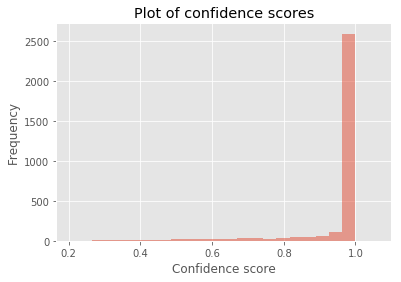

In [138]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

flat_scores_list = [j for sub in all_scores for j in sub] 

plt.xlim([min(flat_scores_list)-0.1, max(flat_scores_list)+0.1])
plt.hist(flat_scores_list, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

### Histogram of low confidence scores
Let’s filter out the high confidence scores to take a closer look at the lower ones.
You can experiment with different thresholds to see how many words fall below that threshold. For this demo, we recommend you use a threshold between 0.3 - 0.35 which corresponds to 4 - 8 human review tasks. All words under this threshold will be sent for human-review. 

In [139]:
THRESHOLD = 0.35

# Filter scores that are less than THRESHOLD
all_bad_scores = [i for i in flat_scores_list if i < THRESHOLD]
print(f"There are {len(all_bad_scores)} words that have confidence score less than {THRESHOLD}")

There are 8 words that have confidence score less than 0.35


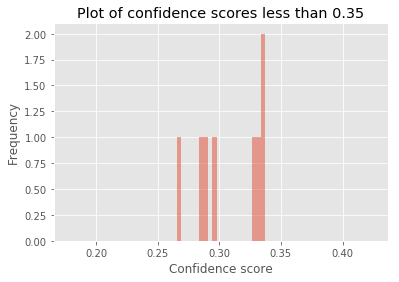

In [140]:
plt.xlim([min(all_bad_scores)-0.1, max(all_bad_scores)+0.1])
plt.hist(all_bad_scores, bins=20, alpha=0.5)
plt.title(f'Plot of confidence scores less than {THRESHOLD}')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

We can see that there is a nontrivial number of words classified with low confidence. As we’ll see later, technical terms are more often mis-transcribed, so it’s important that we correct those mistakes.

## Step 2: Human Review Workflow with A2I

Our next step is create a human review workflow that sends low confidence scores to human reviewers and then retrieves the corrected transcription they provide. This section contains the following steps:

1. Create a work task template that will be displayed to workers for every task. The template will be rendered with input data you provide, instructions to workers, and interactive tools to help workers complete your tasks.
2. Create a human review workflow, also called a flow definition. You use the flow definition to configure details about your human workforce and the human tasks they are assigned.
3. Create a human loop to start the human review workflow, sending data for human review as needed. In this example, you use a custom task type and start human loop tasks using the [Amazon A2I Runtime API](https://docs.aws.amazon.com/augmented-ai/2019-11-07/APIReference/Welcome.html). Each time `StartHumanLoop` is called, a task is sent to human reviewers.

## Create a Private Work Team 


A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers.

For this demo, it is recommended that you create a private workforce and add yourself to the work team. This will allow you to send the A2I human review tasks to yourself so that you can preview the worker UI and complete this demo. 

To create and manage your private workforce, you can use the Labeling workforces page in the Amazon SageMaker console. When following the instructions below, you will have the option to create a private workforce by entering worker emails or importing a pre-existing workforce from an Amazon Cognito user pool. To import a workforce, see Create a Private Workforce (Amazon Cognito Console). 

### To Add yourself to an existing private workforce

If you have already created a private workforce in the same AWS Region as this notebook instance, [add yourself to a private team](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management-private-console.html#add-remove-workers-sm) and copy and paste that work team ARN to set `WORKTEAM_ARN`.

Once you add yourself to the private workteam, you will recieve an email notifying you that you've been invited to the work team. Use the link in that email to reset your password and sign in to the worker portal. The worker portal is where the A2I human review tasks that you create in the following cells will appear. 

### To create a private workforce using worker emails:

You can create a private work team in the Amazon SageMaker console (approximately 15 minutes). 

* Open the **Labeling workforces page** page in the Amazon SageMaker console: https://console.aws.amazon.com/sagemaker/groundtruth#/labeling-workforces.


* If this notebook instance is not in N. Virginia (us-east-1), [change your AWS Region](https://docs.aws.amazon.com/awsconsolehelpdocs/latest/gsg/getting-started.html#select-region) to the same region that this notebook instance is in. 


* In the navigation pane, choose **Labeling workforces**.


* Choose **Private**, then choose **Create private team**.


* Choose **Invite new workers by email**.


* Add your email address and any others that you want to recieve the A2I human review tasks created in this demo. 
    * You will recieve an email notifying you that you've been invited to the work team. Use the link in that email to reset your password and sign in to the worker portal. The worker portal is where the A2I human review tasks that you create in the following cells will appear. 


* Enter an organization name and contact email.


* (Optionally) choose an SNS topic to subscribe the team to so workers are notified by email when new Ground Truth labeling jobs become available.


* Click the Create private team button.

After you import your private workforce, refresh the page. On the Private workforce summary page, you'll see your work team ARN. Enter this ARN in the following cell to set `WORKTEAM_ARN`.

In [156]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-west-2:688520471316:workteam/private-crowd/jashuang-test-workforce"

## Create Resources for an A2I Human Review
Now let's create the resources we'll need to build our human review workflow.

### Create Human Task UI

Amazon A2I uses Liquid, an open-source template language that can be used to “inject” data dynamically into HTML files.

In this walkthrough, we want for each task to enable a human reviewer to watch a section of the video and transcribe the speech they hear. The HTML template consists of three main parts:

1. A video player with a replay button that only allows the reviewer to play the specific subsection
2. A form for the reviewer to type and submit what they hear
3. Logic written in JavaScript to give the replay button its intended functionality

For over 60 other pre-built UIs, check out this [repository](https://github.com/aws-samples/amazon-a2i-sample-task-uis).

Here’s the template you’ll be using (skip ahead to the "Wait For Workers to Complete Task" section to preview what this template looks like):


In [157]:
template = r"""
<head>
    <style>
        h1 {
            color: black;
            font-family: verdana;
            font-size: 150%;
        }
    </style>
</head>
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video id="this_vid">
        <source src="{{ task.input.audioPath | grant_read_access }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <br />
    <br />
    <crowd-button onclick="onClick(); return false;"><h1> Click to play video section!</h1></crowd-button>
    <br />
    Video title: <strong>{{ task.input.video_title }}</strong>
    <br />

    <h3>Instructions</h3>
    <p>Transcribe the audio clip </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>.
    If the text matches the audio, please retype the same transcription.</p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases.
    If a word is cut off in the beginning or end of the video clip, you do NOT need to transcribe that word.
    You also do NOT need to transcribe punctuation at the end of clauses or sentences.
    However, apostrophes and punctuation used in technical terms should still be included, such as "Denny's" or "file_name.txt"</p>
    <p><strong>Important:</strong> If you encounter a technical term that has multiple words,
    please <strong>hyphenate</strong> those words together. For example, "k nearest neighbors" should be transcribed as "k-nearest-neighbors."</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2" label="Your transcription" placeholder="Please enter the transcribed text."></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button and listen carefully to the audio clip. Type what you hear in the box
            below. Replay the clip by clicking the button again, as many times as needed.</p>
    </full-instructions>

</crowd-form>

<script>
    var video = document.getElementById('this_vid');
    video.onloadedmetadata = function() {
        video.currentTime = {{ task.input.start_time }};
    };
    function onClick() {
        video.pause();
        video.currentTime = {{ task.input.start_time }};
        video.play();
        video.ontimeupdate = function () {
            if (video.currentTime >= {{ task.input.end_time }}) {
                video.pause()
            }
        }
    }
</script>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

The `{{ task.input.audioPath | grant_read_access }}` field grants access to and display a video using a path to the video’s location in an S3 bucket. To prevent the reviewer from navigating to irrelevant sections of the video, the `controls` parameter is omitted from the video tag and a single replay button is included to control which section can be replayed.

Below the video player, the `<crowd-text-area>` HTML tag creates a submission form that your reviewer will use to type and submit.

At the end of the HTML snippet, the `<script>` tag contains the logic for the replay button. The `{{ task.input.start_time }}` and `{{ task.input.end_time }}` fields allow you to inject the start and end times of the video subsection you want transcribed for the current task.

Now let's create a Human Task UI resource.

In [158]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-west-2:688520471316:human-task-ui/ui-transcribe-9b77a76c-3b4c-4533-9d1e-735fd245ca40


### Flow Definition

In this section, we're going to create a flow definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well.

For more details and instructions, see [Create a Flow Definition](https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html).


In [159]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'demo-flowdef-transcribe-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "DEMO: Determine Words/Phrases of Audio Clip: " + str(datetime.now())
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH_A2I
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [160]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active


## Human Loops
### Sending sequences of words/phrases of low confidence for review
After setting up our Flow Definition, we're ready to use Amazon Transcribe and initiate human loops. While iterating through the list of transcribed words and their confidence scores, we create a HumanLoop task whenever the confidence score is below some threshold, `CONFIDENCE_SCORE_THRESHOLD`.

An important thing to consider is how we deal with a low-confidence word that is part of a phrase that was also mis-transcribed. To handle these cases, let’s write a function that gets the sequence of words centered about a given index, and the sequence's starting and ending timestamps:

In [170]:
# Use this function to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index, margin):
    """
    gets the words transcribe found at most `margin` away from the input index
    Returns:
        list: words at most 3 away from the input index
        int: starting time of the first word in the list
        int: ending time of the last word in the list
    """
    i = max(0, index - margin)
    j = min(len(words) - 1, index + margin)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

Then, for every word we encounter with low confidence, we send its associated sequence of neighboring words for human review:

In [171]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = THRESHOLD
MARGIN = 3

count = 0
for index in range(num_videos):
    this_uri = folder_path+all_videos[index]
    this_confidences = all_confidences[index]
    
    print("========= " + all_videos[index] + " =========")
    
    i = 0
    while i < len(this_confidences):
        word = this_confidences[i]["content"]
        neighbors, start_time, end_time = get_word_neighbors(this_confidences, i, MARGIN)

        # Our condition for when we want to engage a human for review
        if (this_confidences[i]["confidence"] < CONFIDENCE_SCORE_THRESHOLD):

            # get the original sequence of words
            sequence = ""
            for block in neighbors:
                sequence += block['content'] + " "

            humanLoopName = str(uuid.uuid4())
            # "initialValue": word,
            inputContent = {
                "audioPath": this_uri,
                "start_time": start_time,
                "end_time": end_time,
                "original_words": sequence,
                "video_title": all_videos[index]
            }
            start_loop_response = a2i.start_human_loop(
                HumanLoopName=humanLoopName,
                FlowDefinitionArn=flowDefinitionArn,
                HumanLoopInput={
                    "InputContent": json.dumps(inputContent)
                }
            )
            human_loops_started.append(humanLoopName)
            # print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
            # print(f'Starting human loop with name: {humanLoopName}')
            # print(f'Sending words from times {start_time} to {end_time} to review')
            print(f'The original transcription is "{sequence}" \n')
            
            count = count + 1
            
            # Advance to next word after the margin away from the low-confidence word
            i = i + MARGIN + 1
        else:
            # No human loop created, advance to next word.
            i = i + 1
            # print(f'SentimentScore of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
            # print('No human loop created. \n')
        

print(f'Number of tasks sent to review: {count}')

========= Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 =========
The original transcription is "distributing data sets wanted by putt mode " 

The original transcription is "That's the python Asi que We're getting " 

The original transcription is "the Internet s Oh this is from " 

The original transcription is "this is from Sarraf He's the author " 

The original transcription is "right up here then the title of " 

The original transcription is "but definitely use Lambda to turn your " 

The original transcription is "then edit your ec2 instance or the " 

Number of tasks sent to review: 7


Let's also save the name of each human loop, in case we need to retrieve them later after shutting down this notebook instance.

In [172]:
file_hl = open("human_loops_names.txt","w") 
for name in human_loops_started:
    file_hl.write(name + "\n") 
file_hl.close()
!cat human_loops_names.txt

ad0aaf6d-f890-46e2-95cc-4668aeaeaed7
3a6dd481-b390-4dbf-a355-c8d68de17c3d
cd7db187-0d7f-4ca2-b6b1-c092f265d422
c1ead7b3-bd10-4471-9a46-7c4e6c4b2812
f861f34b-56fb-4c34-80fd-4fafe5a3b53c
0c247a8c-3c17-4ccf-b1fb-2c210063522f
3a4215e6-26fc-45ea-a720-345277395c5f


### Check Status of Human Loop

In [173]:
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')

HumanLoop Name: ad0aaf6d-f890-46e2-95cc-4668aeaeaed7
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-test-sagemaker-6-25/a2i-results/demo-flowdef-transcribe-770dfdef-677e-4160-9473-13ad19cefddf/2020/06/26/22/31/52/ad0aaf6d-f890-46e2-95cc-4668aeaeaed7/output.json'}


HumanLoop Name: 3a6dd481-b390-4dbf-a355-c8d68de17c3d
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-test-sagemaker-6-25/a2i-results/demo-flowdef-transcribe-770dfdef-677e-4160-9473-13ad19cefddf/2020/06/26/22/31/52/3a6dd481-b390-4dbf-a355-c8d68de17c3d/output.json'}


HumanLoop Name: cd7db187-0d7f-4ca2-b6b1-c092f265d422
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-test-sagemaker-6-25/a2i-results/demo-flowdef-transcribe-770dfdef-677e-4160-9473-13ad19cefddf/2020/06/26/22/31/52/cd7db187-0d7f-4ca2-b6b1-c092f265d422/output.json'}


HumanLoop Name: c1ead7b3-bd10-4471-9a46-7c4e6c4b2812
HumanLoop Status: In

### Wait For Workers to Complete Task
We display the link to the private worker portal here for convenience. Check your email (or the email your worker provided) for the login information.

In [174]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://v3t960yxw8.labeling.us-west-2.sagemaker.aws


Here's an example of how a transcription human review task would appear to a worker:

![example task](./images/human_review_task_example.png)

### Check Status of Human Loop Again
Human loop statuses that are completed will display `Completed` below. Note that it is not required to complete all human review tasks before continuing. Having 3-5 completed tasks is typically sufficient to see how technical terms can be extracted from the results.

In [177]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    # print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    # print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)


HumanLoop Name: ad0aaf6d-f890-46e2-95cc-4668aeaeaed7
HumanLoop Status: Completed
HumanLoop Name: 3a6dd481-b390-4dbf-a355-c8d68de17c3d
HumanLoop Status: Completed
HumanLoop Name: cd7db187-0d7f-4ca2-b6b1-c092f265d422
HumanLoop Status: Completed
HumanLoop Name: c1ead7b3-bd10-4471-9a46-7c4e6c4b2812
HumanLoop Status: Completed
HumanLoop Name: f861f34b-56fb-4c34-80fd-4fafe5a3b53c
HumanLoop Status: Completed
HumanLoop Name: 0c247a8c-3c17-4ccf-b1fb-2c210063522f
HumanLoop Status: Completed
HumanLoop Name: 3a4215e6-26fc-45ea-a720-345277395c5f
HumanLoop Status: Completed


### View Task Results

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 `OUTPUT_PATH` when all work is completed.

In [178]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output['humanAnswers'][0]['answerContent'])

{'transcription': 'distributing data sets. What about pipe mode'}
{'transcription': "That's the Python SDK. We're getting"}
{'transcription': 'the Internet. This is from '}
{'transcription': "this is from Sarraf He's the author"}
{'transcription': 'right up here then the title of '}
{'transcription': 'but definitely use Lambda to turn your '}
{'transcription': 'then edit your ec2 instance or the '}


## Step 3: Building custom vocabularies using A2I results

Using the corrected transcriptions from our human reviewers, let’s parse through these results to identify the domain-specific terms that we want to add to a custom vocabulary. 

### Retrieve A2I results
To get the technical terms identified by human review, we first accumulate all human-reviewed words into a list.

In [179]:
from string import punctuation

corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # add the human-reviewed answers split by spaces
    corrected_words += [word.strip(punctuation).lower() for word in json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")]

# Sanity check!
print(corrected_words[0:5])

['distributing', 'data', 'sets', 'what', 'about']


### Filtering out common English words
Now, we want to parse through these words and look for “uncommon” English words. An easy way to do this is to use a large English corpus and verify whether each of our human-reviewed words exists in this corpus:

In [180]:
# Create dictionary of English words
# Note that this corpus of words is not 100% exhaustive
import nltk
nltk.download('words')

from nltk.corpus import words
my_dict=set(words.words()) 

[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [181]:
# Function for removing contractions
# Source: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
def remove_contractions(word_list):
    return [word for word in word_list if word not in contractions]

### View Technical/Uncommon Words
After removing contractions, human-reviewed words that are not in the English language corpus are likely to be the technical terms we are looking for.

In [182]:
word_set = set([])
for word in remove_contractions(corrected_words):
    if word:
        if word.lower() not in my_dict:
            if word.endswith('s') and word[:-1] in my_dict:
                print("")
            elif word.endswith("'s") and word[:-2] in my_dict:
                print("")
            else:
                word_set.add(word)

In [183]:
for word in word_set:
    print(word)

internet
distributing
sdk
ec2


### Create Custom Vocabulary
Using the technical terms identified above, it is now easier to manually create a custom vocabulary of those terms that we want Transcribe to be able to recognize. A custom vocabulary table enables options to tell Amazon Transcribe how each technical term is pronounced and how it should be displayed. More details on how to form a custom vocabulary table can be found at [Create a Custom Vocabulary Using a Table](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html#create-vocabulary-table).

Note that as you process additional videos on the same topic, you can keep updating this list, and the number of new technical terms you'll have to add will likely decrease each time you get a new video.

We've built in advance a custom vocabulary (below) using parsed A2I results from the first and third videos with a 0.5 `THRESHOLD` confidence value. You can use this vocabulary for the rest of the notebook.

In [184]:
finalized_words=[['Phrase','IPA','SoundsLike','DisplayAs'], # This top line denote the column headers of the text file.
                 ['machine-learning','','','machine learning'],
                 ['amazon','','am-uh-zon','Amazon'],
                 ['boto-three','','boe-toe-three','Boto3'],
                 ['T.-three','','tee-three','T3'],
                 ['Sarab','','suh-rob','Sarab'],
                 ['E.C.R.','','ee-see-are','ECR'],
                 ['E.B.S.','','ee-bee-ess','EBS'],
                 ['jupyter','','joo-pih-ter','Jupyter'],
                 ['opt-M.L.','','opt-em-ell','/opt/ml'],
                 ['desktop','','desk-top','desktop'],
                 ['S.-Three','','ess-three','S3'],
                 ['S.D.K.','','ess-dee-kay','SDK'],
                 ['sagemaker','','sage-may-ker','SageMaker'],
                 ['mars-dot-r','','mars-dot-are','mars.R'],
                 ['I.A.M.','','eye-ay-em','IAM'],
                 ['V.P.C.','','vee-pee-see','VPC'],
                 ['E.C.-Two','','ee-see-too','EC2'],
                 ['blazing-text','','blay-zing-text','BlazingText'],
                ]

In this example, let's take a look at several phrases. The term "machine learning" in hyphenated in the first column to indicate that these two distinct words are pronounced. The `SoundsLike` column is left blank since both "machine" and "learning" are common words by themselves that Transcribe likely already knows how to pronounce.

The terms ECR, EBS, SDK, and other acronyms all should have periods after each letter in the `Phrase` column to denote that the letters are pronounced individually by name. This is reinforced in the `SoundsLike` column.

You'll also notice that hybrid acronym phrases like "opt-M.L." and "E.C.-Two" follow a combination of both conventions above.

Finally, the column corresponding to the IPA pronunciation is left blank for every word. The International Phonetic Alphabet (IPA) is the official standardized representation of the sounds of spoken language and may require some familiarity with phonetic notation. If you want to give Transcribe an extremely precise and unambiguous pronunciation guide, you can include IPA pronunciations instead of `SoundsLike` pronunciations by using an [IPA pronunciation key](https://en.wiktionary.org/wiki/Wiktionary:IPA_pronunciation_key) or looking them up in a dictionary.

### Write the Custom Vocabulary Table to a Txt File

In [185]:
custom_vocab_file_name = "customvocab4.txt"
file1 = open(custom_vocab_file_name,"w")
template = '{}\t{}\t{}\t{}\n'
for line in finalized_words:
    file1.write(template.format(line[0],
                                line[1],
                                line[2],
                                line[3])
               )
file1.close()

### Upload Custom Vocabulary File to S3

In [186]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [187]:
upload_file(custom_vocab_file_name, BUCKET)

True

### Create the Custom Vocabulary for Amazon Transcribe
After saving your custom vocabulary table to a text file and uploading it to an S3 bucket, create your custom vocabulary with a specified name so that Amazon Transcribe can use it.

In [191]:
vocab_improved='sagemaker-custom-vocab-3'

In [192]:
transcribe = boto3.client("transcribe")
response = transcribe.create_vocabulary(
    VocabularyName=vocab_improved,
    LanguageCode='en-US',
    VocabularyFileUri='s3://' + BUCKET + '/' + custom_vocab_file_name
)

In [193]:
pp

{   'LanguageCode': 'en-US',
    'ResponseMetadata': {   'HTTPHeaders': {   'connection': 'keep-alive',
                                               'content-length': '96',
                                               'content-type': 'application/x-amz-json-1.1',
                                               'date': 'Fri, 26 Jun 2020 '
                                                       '22:41:10 GMT',
                                               'x-amzn-requestid': '9a7fb4df-d26f-47ab-a7c3-048aae7dca7b'},
                            'HTTPStatusCode': 200,
                            'RequestId': '9a7fb4df-d26f-47ab-a7c3-048aae7dca7b',
                            'RetryAttempts': 0},
    'VocabularyName': 'sagemaker-custom-vocab-3',
    'VocabularyState': 'PENDING'}


Wait until the `VocabularyState` displays `READY` before continuing. This typically takes a few minutes or less.

In [195]:
# Wait for the status of the vocab you created to finish
while True:
    response = transcribe.get_vocabulary(
        VocabularyName=vocab_improved
    )
    status = response['VocabularyState']
    if status in ['READY', 'FAILED']:
        print(status)
        break
    print("Not ready yet...")
    time.sleep(5)

READY


## Step 4: Improved Transcription using custom vocabulary

### Re-transcribe using the Custom Vocabulary
Let's re-transcribe video using our custom vocabulary.

In [196]:
# New job names
# In-sample videos
job_name_custom_vid_0='AWS-custom-0-using-' + vocab_improved + str(time_now)
job_names_custom = [job_name_custom_vid_0]
job_names_custom

['AWS-custom-0-using-sagemaker-custom-vocab-322.01.34']

In [202]:
# Start another transcription job using your custom vocabulary.
transcribe(job_name_custom_vid_0, folder_path+all_videos[0], BUCKET, vocab_name=vocab_improved)

------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-custom-0-using-sagemaker-custom-vocab-322.01.34', 'TranscriptionJobStatus': 'IN_PROGRESS', 'LanguageCode': 'en-US', 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': 's3://jashuang-test-sagemaker-6-25/a2i_transcribe_demo/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4'}, 'Transcript': {}, 'StartTime': datetime.datetime(2020, 6, 26, 22, 47, 40, 458000, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2020, 6, 26, 22, 47, 40, 436000, tzinfo=tzlocal()), 'Settings': {'VocabularyName': 'sagemaker-custom-vocab-3', 'ChannelIdentification': False, 'ShowAlternatives': False}}, 'ResponseMetadata': {'RequestId': 'df0aee28-b208-42e4-874a-2b907187e987', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Fri, 26 Jun 2020 22:47:42 GMT', 'x-amzn-requestid': 'df0aee28-b208-42e4-874a-2b907187e987', 'content-length': '524', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


If you get the error `TypeError: 'TranscribeService' object is not callable`, your execution role may have expired. Refreshing the role connection using the cell below (after uncommenting) is typically able to resolve this issue.

In [ ]:
# from sagemaker import get_execution_role

# ROLE = get_execution_role()
# display(ROLE)

Check the status of your transcription job. Wait until the status displays `COMPLETED`.

In [205]:
while True:
    response = transcribe.get_transcription_job(
        TranscriptionJobName=job_name_custom_vid_0
    )
    status = response['TranscriptionJob']['TranscriptionJobStatus']
    if status in ['COMPLETED', 'FAILED']:
        print(status)
        break
    print("Not ready yet...")
    time.sleep(5)

COMPLETED


In [206]:
all_entire_transcript_custom = []
all_sentences_and_times_custom = []
all_confidences_custom = []
all_scores_custom = []
for i in range(num_videos):
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps(BUCKET,job_names_custom[i]+".json")
    all_entire_transcript_custom.append(entire_transcript_1)
    all_sentences_and_times_custom.append(sentences_and_times_1)
    all_confidences_custom.append(confidences_1)
    all_scores_custom.append(scores_1)

In [207]:
# Sanity check!
print(all_sentences_and_times_custom[0][50])

{'start_time': 202.53, 'end_time': '204.72', 'sentence': 'This is gonna include topics like encryption.', 'min_confidence': 0.7772}


### Write the Improved Transcripts to Txt File

In [208]:
# Save the improved transcripts
i = 1
for list_ in all_sentences_and_times_custom:   
    file = open(f"improved_transcript_{i}.txt","w")
    for tup in list_:
        file.write(tup['sentence'] + "\n") 
    file.close()
    i = i + 1

### Results and Analysis

To analyze metrics on a larger sample size for this workflow, we've generated in advance a ground truth transcript, a transcription before custom vocabulary, and a transcription after custom vocabulary for each of the first four videos of the playlist. The first and third videos are the in-sample videos used to build the custom vocabulary you saw earlier. The second and fourth videos are used as out-sample videos to test Transcribe again after building the custom vocabulary.

Run the following cells to import the transcripts.

In [209]:
!rm -rf a2i_transcribe_demo_results/

In [210]:
%%bash -s "$BUCKET"
mkdir a2i_transcribe_demo_results
aws s3 sync s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files ./a2i_transcribe_demo_results

download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/ground_truth_3.txt to a2i_transcribe_demo_results/ground_truth_3.txt
download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/customvocab4.txt to a2i_transcribe_demo_results/customvocab4.txt
download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/improved_transcript_3.txt to a2i_transcribe_demo_results/improved_transcript_3.txt
download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/improved_transcript_1.txt to a2i_transcribe_demo_results/improved_transcript_1.txt
download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/ground_truth_1.txt to a2i_transcribe_demo_results/ground_truth_1.txt
download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/ground_truth_4.txt to a2i_transcribe_demo_results/ground_truth_4.txt
download: s3://aws-ml-blog/artifacts/a2i-transcribe-custom-demo/demo-txt-files/ground_tr


### Calculating Word Error Rate (WER)

The most common metric for speech recognition accuracy is called word error rate (WER), which can be roughly defined to be the proportion of transcription errors relative to the number of words that were actually said. More details can be found [here](https://en.wikipedia.org/wiki/Word_error_rate).

We'll be using a lightweight open-source Python library called JiWER for calculating WER between transcripts.

For more details, see the open-source [description](https://pypi.org/project/jiwer/).

In [211]:
!pip install jiwer

In [212]:
from jiwer import wer
import jiwer

In [213]:
# Small example
ground_truth = "hello world"
hypothesis = "hello duck"

In [214]:
wer(ground_truth, hypothesis)

0.5

In [215]:
# Create a transformation function to preprocess transcript
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.SentencesToListOfWords(),
    jiwer.SentencesToListOfWords(word_delimiter=" "),
    jiwer.RemoveEmptyStrings()
])

### In-sample video metrics

In [223]:
print("===== In-sample videos =====")
for index in [1,3]:
    print(f"Processing video #{index}")
    # Original transcript
    hypothesis_original = ""
    f1 = open(f"./a2i_transcribe_demo_results/original_transcript_{index}.txt", "r")
    for line in f1:
        hypothesis_original += (line.strip() + " ")
    f1.close()
    
    # Transcript after custom vocabulary
    hypothesis_2 = ""
    f2 = open(f"./a2i_transcribe_demo_results/improved_transcript_{index}.txt", "r")
    for line in f2:
        hypothesis_2 += (line.strip() + " ")
    f2.close()
    
    # Ground truth transcript
    ground_truth = ""
    f3 = open(f"./a2i_transcribe_demo_results/ground_truth_{index}.txt", "r")
    for line in f3:
        ground_truth += (line.strip() + " ")
    f3.close()
    
    # Calculate baseline accuracy
    baseline_accuracy = jiwer.wer(
        ground_truth, 
        hypothesis_original, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The baseline WER (before using custom vocabularies) is {'{:.2%}'.format(baseline_accuracy)}.")
    
    # Calculate new accuracy after custom vocabulary
    new_accuracy = jiwer.wer(
        ground_truth,
        hypothesis_2, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The WER (after using custom vocabularies) is {'{:.2%}'.format(new_accuracy)}.")
    
    print(f"The percentage change in WER score is {'{:.1%}'.format((new_accuracy - baseline_accuracy)/baseline_accuracy)}.\n")

===== In-sample videos =====
Processing video #1
The baseline WER (before using custom vocabularies) is 5.18%.
The WER (after using custom vocabularies) is 2.62%.
The percentage change in WER score is -49.4%.
Processing video #3
The baseline WER (before using custom vocabularies) is 11.94%.
The WER (after using custom vocabularies) is 7.84%.
The percentage change in WER score is -34.4%.


### Out-sample video metrics

In [225]:
print("===== Out-sample videos =====")
for index in [2,4]:
    print(f"Processing video #{index}")
    # Original transcript
    hypothesis_original = ""
    f1 = open(f"./a2i_transcribe_demo_results/original_transcript_{index}.txt", "r")
    for line in f1:
        hypothesis_original += (line.strip() + " ")
    f1.close()
    
    # Transcript after custom vocabulary
    hypothesis_2 = ""
    f2 = open(f"./a2i_transcribe_demo_results/improved_transcript_{index}.txt", "r")
    for line in f2:
        hypothesis_2 += (line.strip() + " ")
    f2.close()
    
    ground_truth = ""
    f3 = open(f"./a2i_transcribe_demo_results/ground_truth_{index}.txt", "r")
    for line in f3:
        ground_truth += (line.strip() + " ")
    f3.close()
    
    # Calculate baseline accuracy
    baseline_accuracy = jiwer.wer(
        ground_truth, 
        hypothesis_original, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The baseline WER (before using custom vocabularies) is {'{:.2%}'.format(baseline_accuracy)}.")
    
    # Calculate new accuracy after custom vocabulary
    new_accuracy = jiwer.wer(
        ground_truth,
        hypothesis_2, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    
    print(f"The WER (after using custom vocabularies) is {'{:.2%}'.format(new_accuracy)}.")
    
    print(f"The percentage change in WER score is {'{:.1%}'.format((new_accuracy - baseline_accuracy)/baseline_accuracy)}.\n")

===== Out-sample videos =====
Processing video #2
The baseline WER (before using custom vocabularies) is 7.55%.
The WER (after using custom vocabularies) is 6.56%.
The percentage change in WER score is -13.1%.

Processing video #4
The baseline WER (before using custom vocabularies) is 10.91%.
The WER (after using custom vocabularies) is 8.98%.
The percentage change in WER score is -17.6%.



## Discussion

We've provided a table summarizing the changes in WER scores below.

| In or Out of Sample | Video | Baseline WER (before custom vocabulary) | New WER (after custom vocabulary) | Percentage Change |
|------------|-------|-----------------------------------------|------------------------------------|-------------------|
| In-sample  | #1     | 5.18%                                   | 2.62%                              | -49%              |
| In-sample  | #3     | 11.94%                                  | 7.84%                              | -34%              |
| Out-sample | #2     | 7.55%                                   | 6.56%                              | -13%              |
| Out-sample | #4     | 10.91%                                  | 8.98%                              | -18%              |

Comparing percentage change values between the in- and out-sample videos, we see that the percentage decreases for the in-sample videos in general exceed those of the out-sample videos. This makes sense since the custom vocabularies were built with the in-sample videos, and there are likely to be other technical terms in the out-sample videos that the custom vocabulary could not have captured yet.

How do we interpret how good the actual WER scores are?

Let's first consider the percentage change column again. By definition, we have $WER=\frac{S+D+I}{N}$, where $S$, $D$, and $I$ are the number of substitution, deletion, and insertion operations, respectively, needed to get from the outputted transcript to the ground truth, and $N$ is the total number of words. The percentage change is then the percentage change in the number of operations needed, so the decreases that we observed look pretty good.

If we consider absolute WER scores, the initial WER of 5.18%, for instance, might already feel sufficiently low — that's only around 1 in 20 words that are mis-transcribed! However, this rate can be misleading, since domain-specific terms are often the least common words spoken (relative to frequent words like “to,” “and,” “I” etc.) but the most commonly mis-transcribed. For applications like search engine optimization (SEO) and video organization by topic, it could be critical that these technical terms are transcribed correctly. Let’s take a look at how our custom vocabulary impacted the transcription rates of several important technical terms:

### Metrics for specific technical terms

#### In-sample videos:

Video #1:

| Technical Term | Ground Truth mentions | Original Transcript Mentions | New Transcript Mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 22                    | 4 (18%)                      | 22 (100%)               | +82%                    |
| EC2            | 15                    | 1 (7%)                       | 15 (100%)               | +93%                    |
| EBS            | 11                    | 7 (64%)                      | 11 (100%)                | +36%                    |
| Jupyter        | 5                     | 0 (0%)                       | 5 (100%)                | +100%                   |
| S3             | 3                     | 0 (0%)                       | 3 (100%)                | +100%                   |
| SDK            | 2                     | 0 (0%)                        | 2 (100%)                | +100%                 |
| BlazingText    | 2                     | 0 (0%)                        | 2 (100%)                | +100%                 |
| IAM            | 1                     | 0 (0%)                        | 1 (100%)                | +100%                 |
| **Total**      | **61**               | **12 (20%)**                  | **61 (100%)**           | **+80%**               |

Video #3:

| Technical Term | Ground Truth mentions | Original Transcript Mentions | New Transcript Mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 17                    | 4 (24%)                      | 17 (100%)               | +76%                    |
| ECR            | 7                     | 0 (0%)                       | 7 (100%)                | +100%                    |
| /opt/ml        | 6                     | 0 (0%)                       | 6 (100%)                | +100%                    |
| mars.R         | 3                     | 0 (0%)                       | 3 (100%)                | +100%                   |
| S3             | 1                     | 0 (0%)                       | 1 (100%)                | +100%                   |
| **Total**      | **34**               | **4 (12%)**                  | **34 (100%)**           | **+88%**               |


#### Out-sample videos:

Video #2:

| Technical Term | Ground Truth mentions | Original Transcript mentions | New Transcript mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 12                    | 3 (25%)                      | 12 (100%)               | +75%                    |
| BlazingText    | 3                     | 0 (0%)                       | 3 (100%)                | +100%                   |
| ECR            | 1                     | 0 (0%)                       | 1 (100%)                | +100%                   |
| **Total**      | **16**               | **3 (19%)**                  | **16 (100%)**           | **+81%**               |

Video #4:

| Technical Term | Ground Truth mentions | Original Transcript mentions | New Transcript mentions | Percentage Point Change |
|----------------|-----------------------|------------------------------|-------------------------|-------------------------|
| SageMaker      | 21                    | 4 (19%)                      | 20 (95%)                | +75%                    |
| EC2            | 11                    | 0 (0%)                       | 11 (100%)               | +100%                    |
| S3             | 7                     | 0 (0%)                       | 6 (86%)                 | +86%                    |
| ECR            | 2                     | 0 (0%)                       | 2 (100%)                | +100%                   |
| SDK            | 1                     | 0 (0%)                       | 1 (100%)                | +100%                   |
| EBS            | 1                     | 1 (100%)                     | 1 (100%)                | +0%                     |
| **Total**      | **43**               | **3 (12%)**                  | **41 (95%)**           | **+83%**               |

Across all videos, the identified technical terms saw improvements of at least 80 percentage points. Now it does look like custom vocabularies were certainly worth the effort!

### Cleaning up
To avoid incurring unnecessary charges, delete resources when not in use.

## Recap

In this post, we walked through an example of how you can improve transcripts from Amazon Transcribe using custom vocabularies and an Amazon A2I human review workflow. This allows you to quickly identify domain-specific terms using your own private workforce and review workflows, and use these terms to build a custom vocabulary so that future mentions of term are transcribed with greater accuracy, at scale. Transcribing key technical terms correctly can be important for doing SEO, enabling highly specific textual queries, and grouping large quantities of video or audio files by important technical terms.

The full proof-of-concept Jupyter notebook can be found at this Github repository. Check out other blog posts covering integrations of Amazon A2I, such as [Using Amazon Textract with Amazon Augmented AI for processing critical documents](https://aws.amazon.com/blogs/machine-learning/using-amazon-textract-with-amazon-augmented-ai-for-processing-critical-documents/) and [Designing human review workflows with Amazon Translate and Amazon Augmented AI](https://aws.amazon.com/blogs/machine-learning/designing-human-review-workflows-with-amazon-translate-and-amazon-augmented-ai/).


## The End!
For a more detailed discussion with additional visuals, check out the accompanying blog post.